In [1807]:
import pandas as pd
import pingouin as pg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import percentileofscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy.stats.mstats import winsorize


In [1808]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [1809]:
def numeric(df, col):
    if df[col].isna().sum() > 0:
        print('NAs Before: ' + str(df[col].isna().sum()))
        value = df[col].mean()
        df[col] = df[col].fillna(value)
        print('NAs After: ' + str(df[col].isna().sum()))
    else:
        print('No NAs')
    return None

In [1810]:
def median_iqr(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    median = df[col].median()
    df.loc[df[col] > upper,col] = median
    df.loc[df[col] < lower,col] = median
    return None

In [1811]:
def onehot(df,col):
    df = pd.get_dummies(df,columns = [col],drop_first = True, dtype = int)
    return None

In [1812]:
train.set_index('Id',inplace = True)
test.set_index('Id',inplace = True)


In [1813]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

**Creating New Features to be used in Model**

In [1815]:
train['Age'] = train.YrSold - train.YearBuilt
train['Is_New'] = np.where(train['YearBuilt'] > 2000, 'Y', 'N')
required_bath_cols = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']
for col in required_bath_cols:
        train[col] = train[col].fillna(0)
        train['TotalBath'] = (
        train['FullBath'] + (0.5 * train['HalfBath']) +
        train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath'])
)
required_sf_cols = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
for col in required_sf_cols:
        train[col] = train[col].fillna(0)
        train['TotalSF'] = (
        train['TotalBsmtSF'] +
        train['1stFlrSF'] +
        train['2ndFlrSF']
    )
print("Engineered features: Age, Is_New, TotalSF, TotalBath created.")



Engineered features: Age, Is_New, TotalSF, TotalBath created.


*Repeat process for test dataset*

In [1817]:
test['Age'] = test.YrSold - test.YearBuilt
test['Is_New'] = np.where(test['YearBuilt'] > 2000, 'Y', 'N')

# --- Process Bath features ---
required_bath_cols = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']
for col in required_bath_cols:
    test[col] = test[col].fillna(0)

# Calculate TotalBath *after* the loop
test['TotalBath'] = (
    test['FullBath'] + (0.5 * test['HalfBath']) +
    test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath'])
)

# --- Process SF features ---
required_sf_cols = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
for col in required_sf_cols:
    test[col] = test[col].fillna(0)

# Calculate TotalSF *after* the loop
test['TotalSF'] = (
    test['TotalBsmtSF'] +
    test['1stFlrSF'] +
    test['2ndFlrSF']
)

print("Engineered features: Age, Is_New, TotalSF, TotalBath created for test set.")

Engineered features: Age, Is_New, TotalSF, TotalBath created for test set.


In [1818]:
features_to_keep = [
    'OverallQual',
    'KitchenQual',
    'ExterQual',     
    'HeatingQC',
    'TotalSF',
    'LotArea',
    'Age',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'TotalBath',
    'GarageCars',
    'BldgType',
    'Neighborhood',
    'MSZoning',
    'SaleCondition',
    'MasVnrArea',
    'Fireplaces',
    'PavedDrive',
    'ScreenPorch',
    'Fence',
    'PoolQC',
    'Alley',
    'MiscFeature',
    'Is_New'
]
test = test[features_to_keep]
features_to_keep.append('SalePrice')
train = train[features_to_keep]

print(f"Columns in 'train' have been filtered. New shape: {train.shape}")
print("Remaining columns:", train.columns.tolist())

Columns in 'train' have been filtered. New shape: (1460, 26)
Remaining columns: ['OverallQual', 'KitchenQual', 'ExterQual', 'HeatingQC', 'TotalSF', 'LotArea', 'Age', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBath', 'GarageCars', 'BldgType', 'Neighborhood', 'MSZoning', 'SaleCondition', 'MasVnrArea', 'Fireplaces', 'PavedDrive', 'ScreenPorch', 'Fence', 'PoolQC', 'Alley', 'MiscFeature', 'Is_New', 'SalePrice']


Now we have reduced the datasets to the 25 columns we chose to use for the modellng, and can continue.

In [1820]:
train['SalePrice'] = np.log10(train['SalePrice'])


In [1821]:
train

,OverallQual,KitchenQual,ExterQual,HeatingQC,TotalSF,LotArea,Age,Foundation,BsmtQual,BsmtExposure,...,MasVnrArea,Fireplaces,PavedDrive,ScreenPorch,Fence,PoolQC,Alley,MiscFeature,Is_New,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,7,Gd,Gd,Ex,2566,8450,5,PConc,Gd,No,...,196.0,0,Y,0,NaN,NaN,NaN,NaN,Y,5.319106
2,6,TA,TA,Ex,2524,9600,31,CBlock,Gd,Gd,...,0.0,1,Y,0,NaN,NaN,NaN,NaN,N,5.258877
3,7,Gd,Gd,Ex,2706,11250,7,PConc,Gd,Mn,...,162.0,1,Y,0,NaN,NaN,NaN,NaN,Y,5.349278
4,7,Gd,TA,Gd,2473,9550,91,BrkTil,TA,No,...,0.0,1,Y,0,NaN,NaN,NaN,NaN,N,5.146128
5,8,Gd,Gd,Ex,3343,14260,8,PConc,Gd,Av,...,350.0,1,Y,0,NaN,NaN,NaN,NaN,N,5.397940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,6,TA,TA,Ex,2600,7917,8,PConc,Gd,No,...,0.0,1,Y,0,NaN,NaN,NaN,NaN,N,5.243038
1457,6,TA,TA,TA,3615,13175,32,CBlock,Gd,No,...,119.0,2,Y,0,MnPrv,NaN,NaN,NaN,N,5.322219
1458,7,Gd,Ex,Ex,3492,9042,69,Stone,TA,No,...,0.0,2,Y,0,GdPrv,NaN,NaN,Shed,N,5.425697


**1: OverallQual**

In [1823]:
train.OverallQual.info()
train.OverallQual.value_counts()
train['OverallQual'] = train['OverallQual'].astype(str)
train['OverallQual'] = train['OverallQual'].apply(lambda x:'1-5' if x in ['1','2','3','4','5'] else '6-10')
train['OverallQual'].value_counts()
onehot(train,'OverallQual')

<class 'pandas.core.series.Series'>
Index: 1460 entries, 1 to 1460
Series name: OverallQual
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 22.8 KB


*Now Repeat for Test*

In [1825]:
test.OverallQual.info()
test.OverallQual.value_counts()
test['OverallQual'] = test['OverallQual'].astype(str)
test['OverallQual'] = test['OverallQual'].apply(lambda x:'1-5' if x in ['1','2','3','4','5'] else '6-10')
test['OverallQual'].value_counts()
onehot(test,'OverallQual')

<class 'pandas.core.series.Series'>
Index: 1459 entries, 1461 to 2919
Series name: OverallQual
Non-Null Count  Dtype
--------------  -----
1459 non-null   int64
dtypes: int64(1)
memory usage: 22.8 KB


**2: KitchenQual**

In [1827]:
print('Train:')
print(train.KitchenQual.value_counts())
onehot(train,'KitchenQual')
print('-'*50)
print('Test:')
print(test.KitchenQual.value_counts())
test.KitchenQual.fillna('TA', inplace = True)
onehot(test,'KitchenQual')

Train:
KitchenQual
TA    735
Gd    586
Ex    100
Fa     39
Name: count, dtype: int64
--------------------------------------------------
Test:
KitchenQual
TA    757
Gd    565
Ex    105
Fa     31
Name: count, dtype: int64


C:\Users\renna\AppData\Local\Temp\ipykernel_14320\1343682071.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test.KitchenQual.fillna('TA', inplace = True)


Using the same pre defined functions, we encoded the kitchenQual.

**3: Alley**

In [1830]:
print('Train:')
print(train.Alley.value_counts())
train['Alley'] = train.Alley.fillna('None')
print(train.Alley.value_counts())
onehot(train,'Alley')
print('-'*50)
print('Test:')
print(test.Alley.value_counts())
test['Alley'] = test.Alley.fillna('None')
print(test.Alley.value_counts())
onehot(train,'Alley')

Train:
Alley
Grvl    50
Pave    41
Name: count, dtype: int64
Alley
None    1369
Grvl      50
Pave      41
Name: count, dtype: int64
--------------------------------------------------
Test:
Alley
Grvl    70
Pave    37
Name: count, dtype: int64
Alley
None    1352
Grvl      70
Pave      37
Name: count, dtype: int64


**4: LotArea:**

Train:


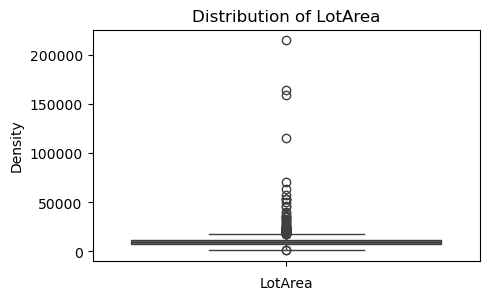

Needs cleaning of outliers
----------------------------------------------------------------------------------------------------
Test:


C:\Users\renna\AppData\Local\Temp\ipykernel_14320\3604007090.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9478.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] > upper,col] = median


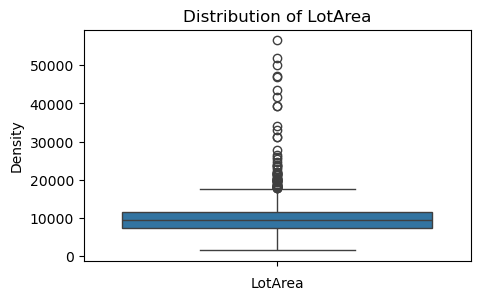

Also needs cleaning of outliers


In [1832]:
print('Train:')
plt.figure(figsize=(5, 3))
sns.boxplot(train.LotArea)
plt.title('Distribution of LotArea')
plt.xlabel('LotArea')
plt.ylabel('Density')
plt.show()
train.LotArea.isna().sum()
median_iqr(train,'LotArea')
print('Needs cleaning of outliers')
print('-'*100)
print('Test:')
plt.figure(figsize=(5, 3))
sns.boxplot(test.LotArea)
plt.title('Distribution of LotArea')
plt.xlabel('LotArea')
plt.ylabel('Density')
plt.show()
print('Also needs cleaning of outliers')
test.LotArea.isna().sum()
median_iqr(test,'LotArea')

There were no missing values, but I did an IQR replace to clean any outliers.

**5: Foundation**

In [1835]:
print('Train:')
print(train.Foundation.value_counts())
train['Foundation'] = train['Foundation'].apply(lambda x:'Other' if x in ['Slab','Wood','Stone']else x)
onehot(train,'Foundation')
print('-'*50)
print('Test:')
print(test.Foundation.value_counts())
test['Foundation'] = test['Foundation'].apply(lambda x:'Other' if x in ['Slab','Wood','Stone']else x)
onehot(test,'Foundation')

Train:
Foundation
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: count, dtype: int64
--------------------------------------------------
Test:
Foundation
PConc     661
CBlock    601
BrkTil    165
Slab       25
Stone       5
Wood        2
Name: count, dtype: int64


Cleaned under represented categories, and encoded wit pre defined functions.

**6: GarageCars**

In [1838]:
print('Train:')
print(train.GarageCars.value_counts())
train.GarageCars = train.GarageCars.fillna(0)
train['GarageCars'] = train['GarageCars'].astype(int).astype(str).apply(lambda x:'3+' if x in ['3','4'] else x)
onehot(train,'GarageCars')
print(test.GarageCars.value_counts())
print('-'*50)
print('Test:')
print(test.GarageCars.value_counts())
test.GarageCars = test.GarageCars.fillna(0)
test['GarageCars'] = test['GarageCars'].astype(int).astype(str).apply(lambda x:'3+' if x in ['3.0','4.0','5.0'] else '2' if x in '2.0' else '1' if x in '1.0' else 0)
onehot(test,'GarageCars')
print(test.GarageCars.value_counts())

Train:
GarageCars
2    824
1    369
3    181
0     81
4      5
Name: count, dtype: int64
GarageCars
2.0    770
1.0    407
3.0    193
0.0     76
4.0     11
5.0      1
Name: count, dtype: int64
--------------------------------------------------
Test:
GarageCars
2.0    770
1.0    407
3.0    193
0.0     76
4.0     11
5.0      1
Name: count, dtype: int64
GarageCars
2    847
1    407
0    205
Name: count, dtype: int64


Cleaned test and train to have equal categorical values then encoded.

**7: Neighborhood**

In [1841]:
print('Train:')
neighborhood_counts = train['Neighborhood'].value_counts()
threshold = 15
to_replace = neighborhood_counts[neighborhood_counts <= threshold].index
train.loc[train['Neighborhood'].isin(to_replace), 'Neighborhood'] = 'Other'
print("--- After Lumping ---")
print(train['Neighborhood'].value_counts())
print('-'*50)
print('Test:')
neighborhood_counts = test['Neighborhood'].value_counts()
threshold = 15
to_replace = neighborhood_counts[neighborhood_counts <= threshold].index
test.loc[test['Neighborhood'].isin(to_replace), 'Neighborhood'] = 'Other'
print("--- After Lumping ---")
print(test['Neighborhood'].value_counts())

Train:
--- After Lumping ---
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Other       22
MeadowV     17
Blmngtn     17
BrDale      16
Name: count, dtype: int64
--------------------------------------------------
Test:
--- After Lumping ---
Neighborhood
NAmes      218
OldTown    126
CollgCr    117
Somerst     96
Edwards     94
NridgHt     89
Gilbert     86
Sawyer      77
SawyerW     66
Mitchel     65
Other       60
NWAmes      58
IDOTRR      56
Crawfor     52
BrkSide     50
Timber      34
NoRidge     30
StoneBr     26
SWISU       23
MeadowV     20
ClearCr     16
Name: count, dtype: int64


Cleaned under representation and encoded using pre defined function.

**8: SaleCondition**

In [1844]:
print('Train:')
print(train.SaleCondition.value_counts())
train['SaleCondition'] = train['SaleCondition'].apply(lambda x: x if x in ['Normal', 'Partial', 'Abnorml'] else 'Other')
print('-'*50)
print('Test:')
print(test.SaleCondition.value_counts())
test['SaleCondition'] = test['SaleCondition'].apply(lambda x: x if x in ['Normal', 'Partial', 'Abnorml'] else 'Other')

Train:
SaleCondition
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: count, dtype: int64
--------------------------------------------------
Test:
SaleCondition
Normal     1204
Partial     120
Abnorml      89
Family       26
Alloca       12
AdjLand       8
Name: count, dtype: int64


**9: MasVnrArea**

In [1846]:
train.MasVnrArea.value_counts()

MasVnrArea
0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: count, Length: 327, dtype: int64

In [1847]:
print('Train:')
print(train.MasVnrArea.value_counts())
train['HasMasVnr'] = np.where(train['MasVnrArea'] > 0, 'yes', 'no')
train = train.drop('MasVnrArea', axis=1)
onehot(train,'HasMasVnr')
print('-'*50)
print('Test:')
print(test.MasVnrArea.value_counts())
test['HasMasVnr'] = np.where(test['MasVnrArea'] > 0, 'yes', 'no')
onehot(test,'HasMasVnr')
test = test.drop('MasVnrArea', axis=1)

Train:
MasVnrArea
0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: count, Length: 327, dtype: int64
--------------------------------------------------
Test:
MasVnrArea
0.0       877
176.0      10
144.0       9
120.0       8
216.0       8
         ... 
647.0       1
1290.0      1
495.0       1
292.0       1
382.0       1
Name: count, Length: 303, dtype: int64


Since many of the values are just 0, replace it with a categorical variable, yes or no.

**10: Fireplaces**

In [1850]:
print('Train:')
print(train.Fireplaces.value_counts())
train['Fireplaces'] = train['Fireplaces'].astype(int).astype(str).apply(lambda x:'2+' if x in ['2','3'] else x)
print(train.Fireplaces.value_counts())
onehot(train,'Fireplaces')
print('-'*50)
print('Test:')
print(test.Fireplaces.value_counts())
test['Fireplaces'] = test['Fireplaces'].astype(int).astype(str).apply(lambda x:'2+' if x in ['2','3','4'] else x)
print(test.Fireplaces.value_counts())
onehot(test,'Fireplaces')

Train:
Fireplaces
0    690
1    650
2    115
3      5
Name: count, dtype: int64
Fireplaces
0     690
1     650
2+    120
Name: count, dtype: int64
--------------------------------------------------
Test:
Fireplaces
0    730
1    618
2    104
3      6
4      1
Name: count, dtype: int64
Fireplaces
0     730
1     618
2+    111
Name: count, dtype: int64


Consolidate and encode the categorical variable.

**11: Fence**

In [1853]:
print('Train:')
print(train.Fence.info())
print(train.Fence.value_counts())
train['Fence'] = train.Fence.fillna('None')
onehot(train,'Fence')
print('-'*50)
print('Test:')
print(test.Fence.info())
print(test.Fence.value_counts())
test['Fence'] = test.Fence.fillna('None')
onehot(test,'Fence')

Train:
<class 'pandas.core.series.Series'>
Index: 1460 entries, 1 to 1460
Series name: Fence
Non-Null Count  Dtype 
--------------  ----- 
281 non-null    object
dtypes: object(1)
memory usage: 22.8+ KB
None
Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64
--------------------------------------------------
Test:
<class 'pandas.core.series.Series'>
Index: 1459 entries, 1461 to 2919
Series name: Fence
Non-Null Count  Dtype 
--------------  ----- 
290 non-null    object
dtypes: object(1)
memory usage: 22.8+ KB
None
Fence
MnPrv    172
GdPrv     59
GdWo      58
MnWw       1
Name: count, dtype: int64


Fill missing values with 'None' and encode.

**12: ExterQual:**

In [1856]:
print('Train:')
print(train.ExterQual.value_counts())
onehot(train,'ExterQual')
print('-'*50)
print('Test:')
print(test.ExterQual.value_counts())
onehot(test,'ExterQual')

Train:
ExterQual
TA    906
Gd    488
Ex     52
Fa     14
Name: count, dtype: int64
--------------------------------------------------
Test:
ExterQual
TA    892
Gd    491
Ex     55
Fa     21
Name: count, dtype: int64


Consilidated under representation

**13: TotalBath**

In [1859]:
onehot(train,'TotalBath')
onehot(test,'TotalBath')


encoded the variable, as we made it ourselves earlier so it is structured how we want.

**14: Age**

Train:


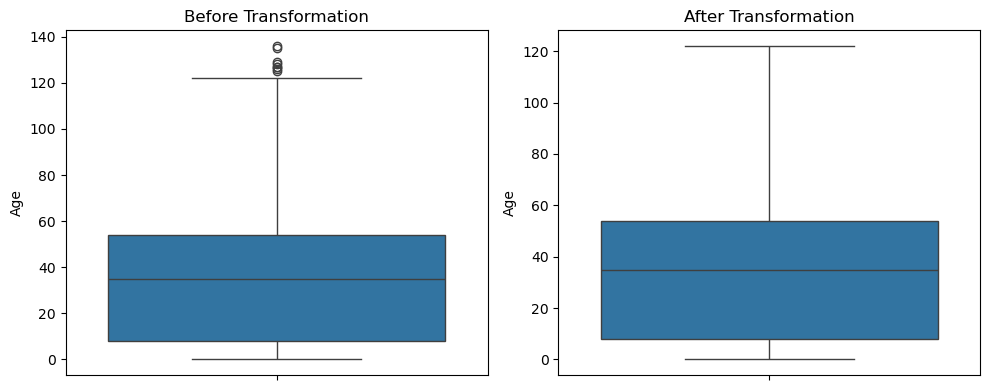

----------------------------------------------------------------------------------------------------
Test:


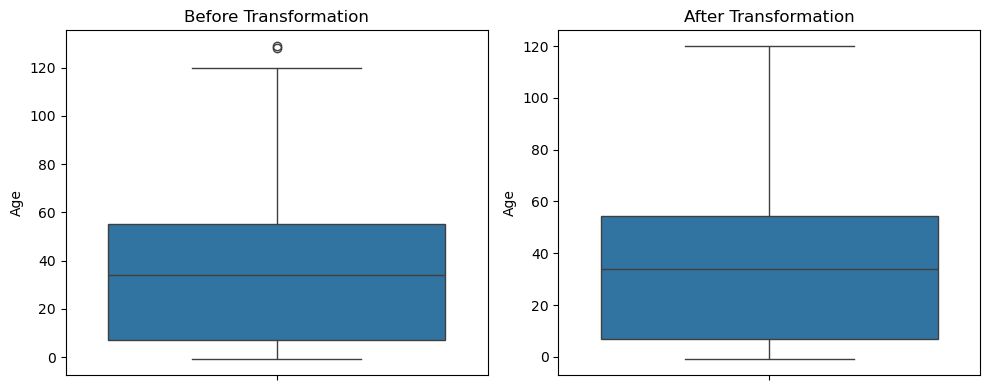

In [1862]:
print('Train:')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.boxplot(train.Age, ax=axes[0])
axes[0].set_title('Before Transformation')
median_iqr(train, 'Age')
sns.boxplot(train.Age, ax=axes[1])
axes[1].set_title('After Transformation')
plt.tight_layout()
plt.show()
print('-'*100)
print('Test:')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.boxplot(test.Age, ax=axes[0])
axes[0].set_title('Before Transformation')
median_iqr(test, 'Age')
sns.boxplot(test.Age, ax=axes[1])
axes[1].set_title('After Transformation')
plt.tight_layout()
plt.show()

Cleaned outliers for age.

Encoded same as all the other similar variables.

**15: BldgType**

In [1866]:
print('Train:')
print(train.BldgType.value_counts())
bldg_type_map = {
    '1Fam': '1Fam',
    'TwnhsE': 'Townhouse',
    'Twnhs': 'Townhouse',
    'Duplex': 'MultiFamily',
    '2fmCon': 'MultiFamily'
}
train['BldgType'] = train['BldgType'].map(bldg_type_map)
print(train.BldgType.value_counts())
onehot(train,'BldgType')
print('-'*50)
print('Test:')
print(test.BldgType.value_counts())
bldg_type_map = {
    '1Fam': '1Fam',
    'TwnhsE': 'Townhouse',
    'Twnhs': 'Townhouse',
    'Duplex': 'MultiFamily',
    '2fmCon': 'MultiFamily'
}
test['BldgType'] = test['BldgType'].map(bldg_type_map)
onehot(test,'BldgType')
print(test.BldgType.value_counts())

Train:
BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: count, dtype: int64
BldgType
1Fam           1220
Townhouse       157
MultiFamily      83
Name: count, dtype: int64
--------------------------------------------------
Test:
BldgType
1Fam      1205
TwnhsE     113
Duplex      57
Twnhs       53
2fmCon      31
Name: count, dtype: int64
BldgType
1Fam           1205
Townhouse       166
MultiFamily      88
Name: count, dtype: int64


Consolidated into less options, encoded.

**16: TotalSF**

Train:


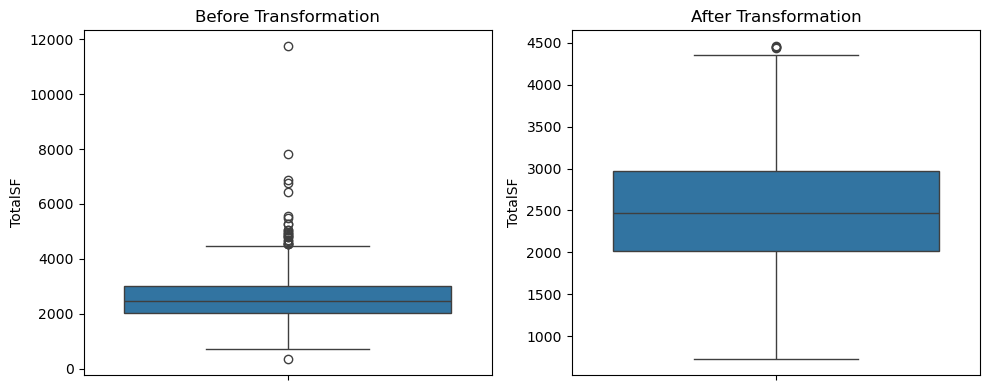

----------------------------------------------------------------------------------------------------
Test:


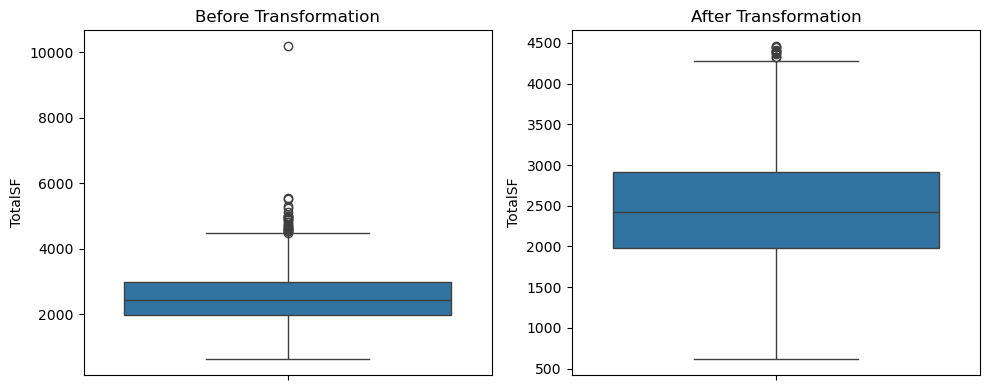

In [1869]:
print('Train:')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.boxplot(train.TotalSF, ax=axes[0])
axes[0].set_title('Before Transformation')
median_iqr(train, 'TotalSF')
sns.boxplot(train.TotalSF, ax=axes[1])
axes[1].set_title('After Transformation')
plt.tight_layout()
plt.show()
print('-'*100)
print('Test:')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.boxplot(test.TotalSF, ax=axes[0])
axes[0].set_title('Before Transformation')
median_iqr(test, 'TotalSF')
sns.boxplot(test.TotalSF, ax=axes[1])
axes[1].set_title('After Transformation')
plt.tight_layout()
plt.show()

Cleaned outliers, same as other variables before.

**17: MiscFeature**

In [1872]:
print('Train:')
print(train.MiscFeature.value_counts())
train.MiscFeature = train['MiscFeature'].apply(lambda x: 'Y' if x in ['Shed','Gar2','Othr','TenC'] else 'N')
onehot(train,'MiscFeature')
print('-'*50)
print('Test:')
print(test.MiscFeature.value_counts())
test.MiscFeature = test['MiscFeature'].apply(lambda x: 'Y' if x in ['Shed','Gar2','Othr','TenC'] else 'N')
onehot(test,'MiscFeature')

Train:
MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64
--------------------------------------------------
Test:
MiscFeature
Shed    46
Gar2     3
Othr     2
Name: count, dtype: int64


Changed to a yes or no categorical variable and encoded.

**18: BsmtQual**

In [1875]:
print('Train:')
train['BsmtQual'] = train['BsmtQual'].fillna('None')
print(train.BsmtQual.value_counts())
onehot(train, 'BsmtQual')
print('-'*50)

print("Test:")
test['BsmtQual'] = test['BsmtQual'].fillna('None')
print(test.BsmtQual.value_counts())
onehot(test, 'BsmtQual')

Train:
BsmtQual
TA      649
Gd      618
Ex      121
None     37
Fa       35
Name: count, dtype: int64
--------------------------------------------------
Test:
BsmtQual
TA      634
Gd      591
Ex      137
Fa       53
None     44
Name: count, dtype: int64


Just filled nulls with 'None' and encoded.

**19: PavedDrive**

In [1878]:
print("Train:")
print(train.PavedDrive.value_counts())
onehot(train, 'PavedDrive')
print("Test:")
print(test.PavedDrive.value_counts())
onehot(test, 'PavedDrive')

Train:
PavedDrive
Y    1340
N      90
P      30
Name: count, dtype: int64
Test:
PavedDrive
Y    1301
N     126
P      32
Name: count, dtype: int64


Simple enough. Just encoded this one.

**20: ScreenPorch**

In [1881]:
print("Train:")
print(train.ScreenPorch.value_counts())
train['ScreenPorch'] = train['ScreenPorch'].fillna(0)
train['Has_ScreenPorch'] = train['ScreenPorch'].apply(lambda x: 'Y' if x > 0 else 'N')
train.ScreenPorch.info()
onehot(train, 'Has_ScreenPorch')
print('-'*50)
print("Test:")
test.ScreenPorch.info()
test['ScreenPorch'] = test['ScreenPorch'].fillna(0)
test['Has_ScreenPorch'] = test['ScreenPorch'].apply(lambda x: 'Y' if x > 0 else 'N')
print(test.ScreenPorch.value_counts())
onehot(test, 'Has_ScreenPorch')

Train:
ScreenPorch
0      1344
192       6
120       5
224       5
189       4
       ... 
291       1
260       1
385       1
156       1
40        1
Name: count, Length: 76, dtype: int64
<class 'pandas.core.series.Series'>
Index: 1460 entries, 1 to 1460
Series name: ScreenPorch
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 22.8 KB
--------------------------------------------------
Test:
<class 'pandas.core.series.Series'>
Index: 1459 entries, 1461 to 2919
Series name: ScreenPorch
Non-Null Count  Dtype
--------------  -----
1459 non-null   int64
dtypes: int64(1)
memory usage: 22.8 KB
ScreenPorch
0      1319
144      10
168       7
216       6
192       5
       ... 
221       1
171       1
135       1
322       1
104       1
Name: count, Length: 75, dtype: int64


Since most values were 0, I also had this one into a yes/no.

**21: Is_New**

In [1884]:
onehot(train,'Is_New')
onehot(test,'Is_New')

Just encoded this, since it is a variable engineered earlier.

**22: KitchenQual**

In [1887]:
print('Train:')
print(train.KitchenQual.value_counts())
onehot(train,'KitchenQual')
print('-'*50)
print('Test:')
print(test.KitchenQual.value_counts())
onehot(test,'KitchenQual')

Train:
KitchenQual
TA    735
Gd    586
Ex    100
Fa     39
Name: count, dtype: int64
--------------------------------------------------
Test:
KitchenQual
TA    758
Gd    565
Ex    105
Fa     31
Name: count, dtype: int64


Used same process as other similar variables earlier.

**22: Pool**

In [1890]:
print('Train')
print(train['PoolQC'].value_counts())
print(train.PoolQC.value_counts())
categories_to_keep = ['Gd', 'Ex', 'Fa']
train['Pool'] = train['PoolQC'] = train['PoolQC'].apply(lambda x: 'Y' if x in categories_to_keep else 'N')
train.drop('PoolQC', axis = 1)
print(train['Pool'].value_counts())
onehot(train,'Pool')
print('-'*50)
print('Test')
print(test['PoolQC'].value_counts())
print(test.PoolQC.value_counts())
categories_to_keep = ['Gd', 'Ex', 'Fa']
test['Pool'] = test['PoolQC'] = test['PoolQC'].apply(lambda x: 'Y' if x in categories_to_keep else 'N')
test.drop('PoolQC', axis = 1)
onehot(test,'Pool')
print(test['Pool'].value_counts())

Train
PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64
PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64
Pool
N    1453
Y       7
Name: count, dtype: int64
--------------------------------------------------
Test
PoolQC
Ex    2
Gd    1
Name: count, dtype: int64
PoolQC
Ex    2
Gd    1
Name: count, dtype: int64
Pool
N    1456
Y       3
Name: count, dtype: int64


Changed so Pool is just a yes/No Variable and encoded.

**23: BsmtExposure** 

In [1893]:
print('Train:')
train['BsmtExposure'] = train['BsmtExposure'].fillna('None')
print(train.BsmtExposure.value_counts())
onehot(train,'BsmtExposure')
print('-'*50)
print('Test:')
test['BsmtExposure'] = test['BsmtExposure'].fillna('None')
print(test.BsmtExposure.value_counts())
onehot(test,'BsmtExposure')

Train:
BsmtExposure
No      953
Av      221
Gd      134
Mn      114
None     38
Name: count, dtype: int64
--------------------------------------------------
Test:
BsmtExposure
No      951
Av      197
Gd      142
Mn      125
None     44
Name: count, dtype: int64


Filled all NA with 'None', and encoded.

**24: HeatingQC:**

In [1896]:
print('Train:')
print(train.HeatingQC.value_counts())
onehot(train,'HeatingQC')
print('-'*50)
print('Test:')
print(test.HeatingQC.value_counts())
onehot(test,'HeatingQC')

Train:
HeatingQC
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: count, dtype: int64
--------------------------------------------------
Test:
HeatingQC
Ex    752
TA    429
Gd    233
Fa     43
Po      2
Name: count, dtype: int64


Just encoded same as any other similar variable.

**25: MSZoning**

In [1899]:
print("Train:")
print(train.MSZoning.value_counts())
categories_to_keep = ['RL', 'RM', 'FV']
train['MSZoning'] = train['MSZoning'].apply(lambda x: x if x in categories_to_keep else 'Other')
print("After Cleaning")
print(train.MSZoning.value_counts())
onehot(train,'MSZoning')
print('-'*50)
print("Test:")
print(test.MSZoning.value_counts())
categories_to_keep = ['RL', 'RM', 'FV']
test['MSZoning'] = test['MSZoning'].apply(lambda x: x if x in categories_to_keep else 'Other')
onehot(test,'MSZoning')
print("After Cleaning")
print(test.MSZoning.value_counts())

Train:
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
After Cleaning
MSZoning
RL       1151
RM        218
FV         65
Other      26
Name: count, dtype: int64
--------------------------------------------------
Test:
MSZoning
RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: count, dtype: int64
After Cleaning
MSZoning
RL       1114
RM        242
FV         74
Other      29
Name: count, dtype: int64


**Interaction Terms:**


In [1901]:
def test_interaction(var1, var2, base_formula, data):

    no_inter_model = smf.ols(base_formula, data=data).fit()

    interaction_formula = f"{base_formula} + {var1}:{var2}"
    
    yes_inter_model = smf.ols(interaction_formula, data=data).fit()

    print(f"\n--- ANOVA Test for Interaction: {var1} : {var2} ---")
    print(anova_lm(no_inter_model, yes_inter_model))
    print("-" * (50 + len(var1) + len(var2)))


In [1903]:

base_formula = (
    "SalePrice ~ OverallQual + KitchenQual + ExterQual + HeatingQC + "
    "TotalSF + LotArea + Age + Foundation + BsmtQual + BsmtExposure + "
    "TotalBath + GarageCars + BldgType + Neighborhood + MSZoning + "
    "SaleCondition + HasMasVnr + Fireplaces + PavedDrive + ScreenPorch + "
    "Fence + PoolQC + Alley + MiscFeature + Is_New"
)

In [1904]:
print('Lot Area vs Neighborhood Interaction')
test_interaction(var1="Neighborhood", 
                 var2="LotArea", 
                 base_formula= base_formula,
                 data=train)
print('Is_New vs ExterQual Interaction')
test_interaction(var1="Is_New", 
                 var2="ExterQual", 
                 base_formula= base_formula,
                 data=train)
print('Neighborhood vs OverallQual Interaction')
test_interaction(var1="Neighborhood", 
                 var2="OverallQual", 
                 base_formula= base_formula,
                 data=train)
print('Age vs Fireplaces Interaction')
test_interaction(var1="Age", 
                 var2="Fireplaces", 
                 base_formula= base_formula,
                 data=train)
test_interaction(var1="Foundation", 
                 var2="TotalSF", 
                 base_formula= base_formula,
                 data=train)

Lot Area vs Neighborhood Interaction

--- ANOVA Test for Interaction: Neighborhood : LotArea ---
   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0    1385.0  5.348199      0.0       NaN       NaN       NaN
1    1363.0  5.147777     22.0  0.200423  2.412127  0.000272
---------------------------------------------------------------------
Is_New vs ExterQual Interaction

--- ANOVA Test for Interaction: Is_New : ExterQual ---
   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0    1385.0  5.348199      0.0       NaN       NaN       NaN
1    1383.0  5.323005      2.0  0.025195  3.273003  0.038186
-----------------------------------------------------------------
Neighborhood vs OverallQual Interaction

--- ANOVA Test for Interaction: Neighborhood : OverallQual ---
   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0    1385.0  5.348199      0.0       NaN       NaN       NaN
1    1368.0  5.135894     17.0  0.212305  3.326454  0.000005
--------------------------

All 5 Interaction Scores Work.

In [1906]:
predictors = [
    'OverallQual', 'KitchenQual', 'ExterQual', 'HeatingQC', 'TotalSF',
    'LotArea', 'Age', 'Foundation', 'BsmtQual', 'BsmtExposure', 'TotalBath',
    'GarageCars', 'BldgType', 'Neighborhood', 'MSZoning', 'SaleCondition',
    'HasMasVnr', 'Fireplaces', 'PavedDrive', 'ScreenPorch', 'Fence',
    'PoolQC', 'Alley', 'MiscFeature', 'Is_New'
]

In [1907]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
model_dummies = pd.get_dummies(train, dtype = int,drop_first = True)
predictors = model_dummies.drop(columns = 'SalePrice')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif['variable'] = predictors.columns
vif.head(40)

C:\Users\renna\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF,variable
0,38.599460,TotalSF
1,22.650050,LotArea
2,19.790518,Age
3,19.650587,TotalBath
4,7.441728,ScreenPorch
5,6.023534,OverallQual_6-10
6,2.213508,KitchenQual_Fa
7,11.532554,KitchenQual_Gd
8,17.801065,KitchenQual_TA
9,1.880112,ExterQual_Fa


**OLS Model:**

In [1909]:
import statsmodels.api as sm
from patsy import dmatrices, build_design_matrices
import numpy as np
import re
import pandas as pd

# --- 1. OLS Model: Fit, Summary, and Metrics (on TRAIN set) ---
print("==============================================================================")
print("                           1. OLS MODEL")
print("==============================================================================")

# Define the full formula
full_formula = (
    base_formula + 
    '+ LotArea * Neighborhood + Age * Fireplaces + Foundation*TotalSF + '
    'Is_New*ExterQual + Neighborhood*OverallQual'
)

y, X = dmatrices(full_formula, data=train, return_type='dataframe')

# Fit the OLS model
sm_ols_model = sm.OLS(y, X)
sm_ols_results = sm_ols_model.fit()

# Calculate OLS in-sample metrics
ols_in_sample_mse = sm_ols_results.mse_resid
ols_in_sample_rmsle = np.sqrt(ols_in_sample_mse)
ols_in_sample_r2 = sm_ols_results.rsquared
ols_in_sample_r2_adj = sm_ols_results.rsquared_adj

print(sm_ols_results.summary())
print("\n--- OLS In-Sample Performance Metrics ---")
print(f"R-squared:                 {ols_in_sample_r2:.4f}")
print(f"Adjusted R-squared:        {ols_in_sample_r2_adj:.4f}")
print(f"Mean Squared Error (MSE): {ols_in_sample_mse:.4f}")
print(f"Root Mean Squared Log Error (RMSLE): {ols_in_sample_rmsle:.4f}\n")

print("\n==============================================================================")
print("                2. PREDICTING ON TEST SET (OLS)")
print("==============================================================================")

# A) Robustly normalize 'test' set types to match 'train'
print("Normalizing 'test' set data types with robust grouping...")
test['GarageCars'] = test['GarageCars'].astype(str).str.replace(r'\.0$', '', regex=True)
test['GarageCars'] = test['GarageCars'].apply(
    lambda x: x if x in ['0', '1', '2'] else '3+' 
)
test['Fireplaces'] = test['Fireplaces'].astype(str).str.replace(r'\.0$', '', regex=True)
test['Fireplaces'] = test['Fireplaces'].apply(
    lambda x: x if x in ['0', '1'] else '2+'
)

print("Building patsy test matrix (for OLS)...")
X_test = build_design_matrices([X.design_info], test, return_type='dataframe')[0]

print("Running OLS prediction...")
ols_preds_log = sm_ols_results.predict(X_test)

print("Adding predictions to 'test' dataframe...")
test['pred_saleprice_ols'] = 10**ols_preds_log

test = test.reset_index()
print(test[['Id', 'pred_saleprice_ols']].head())

                           1. OLS MODEL
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     88.39
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        09:59:04   Log-Likelihood:                 2083.9
No. Observations:                1460   AIC:                            -3926.
Df Residuals:                    1339   BIC:                            -3286.
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

#### **OLS Results:**

| Metric                      | Value   |
| :-------------------------- | :------ |
| R-squared                   | 0.888   |
| Adj. R-squared              | 0.878   |
| Mean Squared Error (MSE)   | 0.0037  |
| Root Mean Squared Error (RMSLE) | 0.0606  |

The final R^2 is 0.88, with RMSLE of 0.061, the model seems to work well!

#### **Normality Test:**

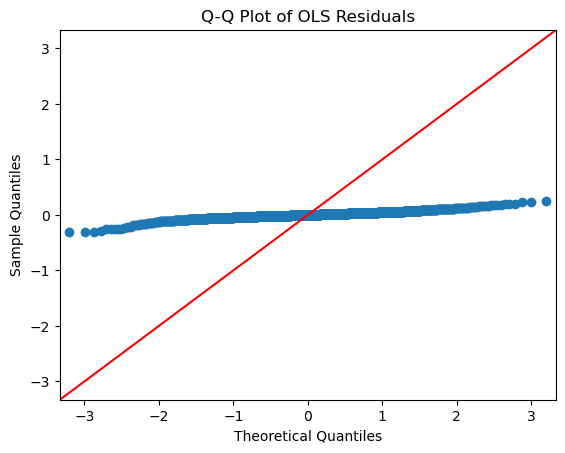

In [2005]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
sm.qqplot(sm_ols_results.resid, line='45')
plt.title('Q-Q Plot of OLS Residuals')
plt.show()

While the line is pertty flat, it is mostly straight, so I think we cna stick with it.

#### **HeteroSchedasticity**

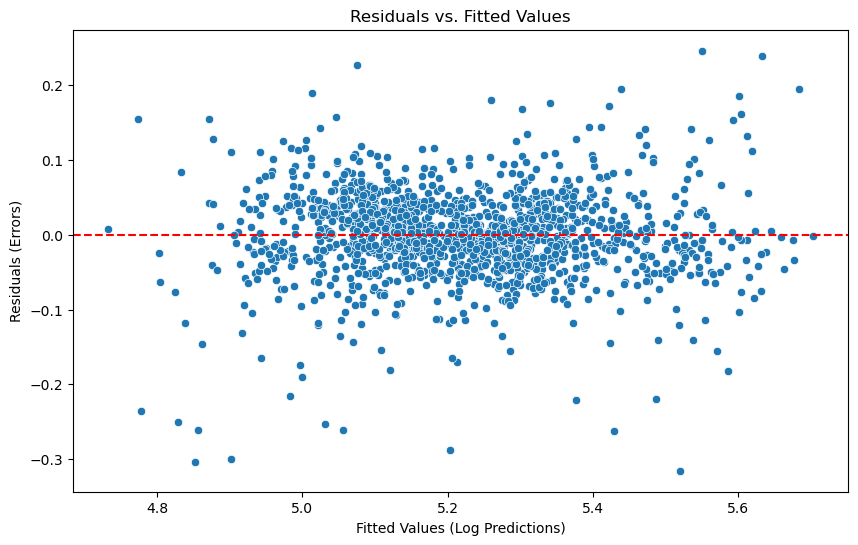

In [2010]:
fitted_vals = sm_ols_results.fittedvalues
residuals = sm_ols_results.resid
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values (Log Predictions)')
plt.ylabel('Residuals (Errors)')
plt.show()

It all remains relatively straight, with only a few outliers here and there.

#### **Nonlinearity Test**

In [2016]:
from statsmodels.stats.diagnostic import linear_rainbow

rainbow_test = linear_rainbow(sm_ols_results)

print(f"\nRainbow Test statistic: {rainbow_test[0]:.4f}")
print(f"Rainbow Test p-value: {rainbow_test[1]:.4f}")

# Interpretation
if rainbow_test[1] < 0.05:
    print("\nResult: The model is not linear (p < 0.05).")
else:
    print("\nResult: The model is linear (p > 0.05).")


Rainbow Test statistic: 0.9340
Rainbow Test p-value: 0.8115

Result: The model is linear (p > 0.05).


All the tests seem to suffice to continue with further modelling.

#### **XGBoost Model:**

In [1963]:
import xgboost as xgb
import re
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from patsy import dmatrices, build_design_matrices # Added patsy imports

# --- 1. Prepare Data ---
# X and y are assumed to be from your patsy dmatrices call on 'train'
X_xgb = X.copy()

def clean_col_name(col_name):
    return re.sub(r"\[|\]|<", "_", col_name)

X_xgb.columns = [clean_col_name(col) for col in X_xgb.columns]

# --- 2. Define and Train Model ---
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost model on all training data...")
# We must use .values.flatten() on 'y' for a clean fit
xgb_model.fit(X_xgb, y.values.flatten())
print("Model training complete.")

# --- 3. Calculate Performance Statistics ---
y_pred_train = xgb_model.predict(X_xgb)
actuals_log = y.values.flatten()

# MSE (which is MSLE)
xgb_in_sample_mse = mean_squared_error(actuals_log, y_pred_train)

# RMSLE
xgb_in_sample_rmsle = np.sqrt(xgb_in_sample_mse)

# R-squared
xgb_in_sample_r2 = r2_score(actuals_log, y_pred_train)

print("\n--- XGBoost In-Sample Performance Metrics ---")
print(f"R-squared:                 {xgb_in_sample_r2:.4f}")
print(f"Mean Squared Error (MSLE): {xgb_in_sample_mse:.4f}")
print(f"Root Mean Squared Error (RMSLE): {xgb_in_sample_rmsle:.4f}")

# --- 4. Get Feature Importance Statistics ---
importances = xgb_model.feature_importances_
feature_names = X_xgb.columns

# Create a DataFrame to view them clearly
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame from most to least important and print the top 20
print("\n--- XGBoost Feature Importances (Top 20) ---")
print(importance_df.sort_values(by='Importance', ascending=False).head(20))


# --- 5. PREDICTION ON TEST SET (XGBoost Model) ---
print("\n==============================================================================")
print("                5. PREDICTING ON TEST SET (XGBoost)")
print("==============================================================================")

# A) Robustly normalize 'test' set
print("Normalizing 'test' set (handling NaNs and types)...")

# --- THE FIX: Fill NaNs for numeric columns in your formula ---
# This stops patsy from dropping the row and fixes the 1458 vs 1459 error.
numeric_cols = ['TotalSF', 'TotalBath', 'Age', 'LotArea', 'MasVnrArea', 'ScreenPorch']
for col in numeric_cols:
    if col in test.columns:
        test[col] = test[col].fillna(0)

# Your existing type-casting for categoricals
test['GarageCars'] = test['GarageCars'].astype(str).str.replace(r'\.0$', '', regex=True)
test['GarageCars'] = test['GarageCars'].apply(
    lambda x: x if x in ['0', '1', '2'] else '3+' 
)
test['Fireplaces'] = test['Fireplaces'].astype(str).str.replace(r'\.0$', '', regex=True)
test['Fireplaces'] = test['Fireplaces'].apply(
    lambda x: x if x in ['0', '1'] else '2+'
)

# B) Build the base patsy test matrix
print("Building base patsy test matrix...")
# This will now produce 1459 rows
X_test_patsy = build_design_matrices([X.design_info], test, return_type='dataframe')[0]

# C) Build the XGBoost test matrix (by cleaning column names)
print("Building XGBoost-compatible test matrix (cleaning column names)...")
X_test_xgb = X_test_patsy.copy()
X_test_xgb.columns = [clean_col_name(col) for col in X_test_xgb.columns]

# D) Run XGBoost Prediction
print("Running XGBoost prediction...")
xgb_preds_log = xgb_model.predict(X_test_xgb) # This will now have 1459 predictions

# E) Add Predictions to 'test' DataFrame and un-log
print("Adding predictions to 'test' dataframe...")
test['pred_saleprice_xgb'] = 10**xgb_preds_log # This will now work

# F) Reset Index to Show 'Id'
test = test.reset_index()

print("\n--- XGBoost Predictions Added to 'test' DataFrame ---")
# Show the Id and the new prediction column
print(test[['Id', 'pred_saleprice_xgb']].head())

Training XGBoost model on all training data...
Model training complete.

--- XGBoost In-Sample Performance Metrics ---
R-squared:                 0.9460
Mean Squared Error (MSLE): 0.0016
Root Mean Squared Error (RMSLE): 0.0403

--- XGBoost Feature Importances (Top 20) ---
                                         Feature  Importance
25                              GarageCars_T.3+_    0.117982
1                            OverallQual_T.6-10_    0.090197
98                   Foundation_T.PConc_:TotalSF    0.082930
7                                ExterQual_T.TA_    0.069358
95                                       TotalSF    0.062164
125                                    TotalBath    0.031156
4                              KitchenQual_T.TA_    0.026248
77   Neighborhood_T.Crawfor_:OverallQual_T.6-10_    0.018288
24                               GarageCars_T.2_    0.017904
52                                MSZoning_T.RM_    0.015503
122                                          Age    0.01

#### **Results:**
| Metric                      | Value           |
| :-------------------------- | :-------------- |
| R-squared                   | 0.9460          |
| Mean Squared Error (MSLE)   | 0.0016          |
| Root Mean Squared Error (RMSLE) | 0.0403          |
| **Most Important Feature** | `GarageCars_T.3+` |
| (Importance Score)          | 0.1179          |

With an r^2 of 0.946 and RMSLE of 0.0403, the model performed great.

In [1970]:
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from patsy import dmatrices, build_design_matrices # Added patsy imports
import re # Added re
import pandas as pd # Added pandas

# --- 1. Define and Fit the Lasso Model ---
# X and y are assumed to be from your patsy dmatrices call on 'train'
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42, max_iter=10000))
])

print("Fitting LassoCV model with scaling...")
pipeline.fit(X, y.values.flatten())

# You can see which alpha it found!
best_alpha = pipeline.named_steps['lasso'].alpha_
print(f"LassoCV found the best alpha: {best_alpha:.6f}")

# --- 2. Calculate In-Sample Performance ---
predictions_log = pipeline.predict(X)
actuals_log = y.values.flatten()
lasso_rsquared = r2_score(actuals_log, predictions_log)
lasso_mse = mean_squared_error(actuals_log, predictions_log)
lasso_rmsle = np.sqrt(lasso_mse)

print("\n--- Lasso In-Sample Performance Metrics ---")
print(f"R-squared:                 {lasso_rsquared:.4f}")
print(f"Mean Squared Error (MSLE): {lasso_mse:.4f}")
print(f"Root Mean Squared Error (RMSLE): {lasso_rmsle:.4f}")


# --- 3. PREDICTION ON TEST SET (Lasso Model) ---
print("\n==============================================================================")
print("                3. PREDICTING ON TEST SET (Lasso)")
print("==============================================================================")

# A) Robustly normalize 'test' set
print("Normalizing 'test' set (handling NaNs and types)...")

# Fill NaNs for numeric columns to prevent row-dropping
numeric_cols = ['TotalSF', 'TotalBath', 'Age', 'LotArea', 'MasVnrArea', 'ScreenPorch']
for col in numeric_cols:
    if col in test.columns:
        test[col] = test[col].fillna(0)

# Type-casting for categoricals to prevent PatsyError
test['GarageCars'] = test['GarageCars'].astype(str).str.replace(r'\.0$', '', regex=True)
test['GarageCars'] = test['GarageCars'].apply(
    lambda x: x if x in ['0', '1', '2'] else '3+' 
)
test['Fireplaces'] = test['Fireplaces'].astype(str).str.replace(r'\.0$', '', regex=True)
test['Fireplaces'] = test['Fireplaces'].apply(
    lambda x: x if x in ['0', '1'] else '2+'
)

# B) Build the base patsy test matrix
print("Building base patsy test matrix...")
X_test_patsy = build_design_matrices([X.design_info], test, return_type='dataframe')[0]

# C) Run Lasso Prediction
print("Running Lasso prediction...")
lasso_preds_log = pipeline.predict(X_test_patsy) 

# D) Add Predictions to 'test' DataFrame and un-log
print("Adding predictions to 'test' dataframe...")
test['pred_saleprice_lasso'] = 10**lasso_preds_log

# --- THIS IS THE FIX ---
# E) Reset Index only if 'Id' isn't already a column
if 'Id' not in test.columns and 'index' not in test.columns and 'level_0' not in test.columns:
    print("Resetting index to create Id column...")
    test = test.reset_index()
    # Rename the new 'index' column to 'Id'
    if 'index' in test.columns:
        test = test.rename(columns={'index': 'Id'})
else:
    print("Index already reset in a previous step.")
# --- END FIX ---

print("\n--- Lasso Predictions Added to 'test' DataFrame ---")
# Show the Id and the new prediction column
print(test[['Id', 'pred_saleprice_lasso']].head())

Fitting LassoCV model with scaling...
LassoCV found the best alpha: 0.000434

--- Lasso In-Sample Performance Metrics ---
R-squared:                 0.8835
Mean Squared Error (MSLE): 0.0035
Root Mean Squared Error (RMSLE): 0.0592

                3. PREDICTING ON TEST SET (Lasso)
Normalizing 'test' set (handling NaNs and types)...
Building base patsy test matrix...
Running Lasso prediction...
Adding predictions to 'test' dataframe...
Index already reset in a previous step.

--- Lasso Predictions Added to 'test' DataFrame ---
     Id  pred_saleprice_lasso
0  1461         109184.853448
1  1462         145408.220510
2  1463         178907.367061
3  1464         186849.115584
4  1465         197191.372313


#### **Results:**
| Metric                      | Value    |
| :-------------------------- | :------- |
| R-squared                   | 0.8835   |
| Mean Squared Error (MSLE)   | 0.0035   |
| Root Mean Squared Error (RMSLE) | 0.0592   |

The final R^2 is 0.88, with RMSLE of 0.059, all up to par with what we're looking for.

In [1973]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from patsy import dmatrices, build_design_matrices 
import re

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=np.logspace(-6, 6, 100))) # RidgeCV finds the best alpha
])

print("Fitting RidgeCV model with scaling...")
ridge_pipeline.fit(X, y.values.flatten())

best_alpha = ridge_pipeline.named_steps['ridge'].alpha_
print(f"RidgeCV found the best alpha: {best_alpha:.6f}")

predictions_log = ridge_pipeline.predict(X)
actuals_log = y.values.flatten()

r2 = r2_score(actuals_log, predictions_log)
mse = mean_squared_error(actuals_log, predictions_log)
rmsle = np.sqrt(mse)
p = X.shape[1] - 1
n = X.shape[0]
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("\n--- Ridge In-Sample Performance Metrics ---")
print(f"R-squared:                 {r2:.4f}")
print(f"Adjusted R-squared:        {r2_adj:.4f}")
print(f"Mean Squared Error (MSLE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSLE): {rmsle:.4f}")


print("\n==============================================================================")
print("                6. PREDICTING ON TEST SET (Ridge)")
print("==============================================================================")


numeric_cols = ['TotalSF', 'TotalBath', 'Age', 'LotArea', 'MasVnrArea', 'ScreenPorch']
for col in numeric_cols:
    if col in test.columns:
        test[col] = test[col].fillna(0)

test['GarageCars'] = test['GarageCars'].astype(str).str.replace(r'\.0$', '', regex=True)
test['GarageCars'] = test['GarageCars'].apply(
    lambda x: x if x in ['0', '1', '2'] else '3+' 
)
test['Fireplaces'] = test['Fireplaces'].astype(str).str.replace(r'\.0$', '', regex=True)
test['Fireplaces'] = test['Fireplaces'].apply(
    lambda x: x if x in ['0', '1'] else '2+'
)

print("Building base patsy test matrix...")
X_test_patsy = build_design_matrices([X.design_info], test, return_type='dataframe')[0]

print("Running Ridge prediction...")
ridge_preds_log = ridge_pipeline.predict(X_test_patsy) 

print("Adding predictions to 'test' dataframe...")
test['pred_saleprice_ridge'] = 10**ridge_preds_log # This will now work

if 'Id' not in test.columns and 'index' not in test.columns:
    print("Resetting index to create Id column...")
    test = test.reset_index()
    # Rename the new 'index' column to 'Id'
    if 'index' in test.columns:
        test = test.rename(columns={'index': 'Id'})
else:
    print("Index already reset in a previous step.")

print("\n--- Ridge Predictions Added to 'test' DataFrame ---")
print(test[['Id', 'pred_saleprice_ridge']].head())

Fitting RidgeCV model with scaling...
RidgeCV found the best alpha: 43.287613

--- Ridge In-Sample Performance Metrics ---
R-squared:                 0.8848
Adjusted R-squared:        0.8739
Mean Squared Error (MSLE): 0.0035
Root Mean Squared Error (RMSLE): 0.0589

                6. PREDICTING ON TEST SET (Ridge)
Normalizing 'test' set (handling NaNs and types)...
Building base patsy test matrix...
Running Ridge prediction...
Adding predictions to 'test' dataframe...
Index already reset in a previous step.

--- Ridge Predictions Added to 'test' DataFrame ---
     Id  pred_saleprice_ridge
0  1461         108205.764754
1  1462         140970.814999
2  1463         186125.785704
3  1464         185285.891124
4  1465         200055.131736


#### **Results:**

| Metric                      | Value      |
| :-------------------------- | :--------- |
| R-squared                   | 0.8848     |
| Adjusted R-squared          | 0.8739     |
| Mean Squared Error (MSLE)   | 0.0035     |
| Root Mean Squared Error (RMSLE) | 0.0589     |



#### **Summary**
| Model | R-squared | Adj. R-squared | MSLE | RMSLE |
| :--- | :--- | :--- | :--- | :--- |
| **XGBoost** | **0.9460** | N/A | **0.0016** | **0.0403** |
| **OLS** | 0.8880 | 0.8780 | 0.0037 | 0.0606 |
| **Ridge** | 0.8848 | 0.8739 | 0.0035 | 0.0589 |
| **Lasso** | 0.8835 | N/A | 0.0035 | 0.0592 |

|:---|
|*While the XGBoost seems to have performed the best, that may be because of overfitting*|

In [1992]:
test[['Id', 'pred_saleprice_ols', 'pred_saleprice_xgb', 'pred_saleprice_lasso', 'pred_saleprice_ridge']].head(15)

,Id,pred_saleprice_ols,pred_saleprice_xgb,pred_saleprice_lasso,pred_saleprice_ridge
0,1461,107457.150906,99706.179688,109184.853448,108205.764754
1,1462,137375.761543,166794.531250,145408.220510,140970.814999
2,1463,197638.349738,176184.187500,178907.367061,186125.785704
3,1464,184829.675357,194484.984375,186849.115584,185285.891124
4,1465,198641.176082,193072.468750,197191.372313,200055.131736
5,1466,172247.764537,176927.406250,173102.507354,172491.629832
6,1467,175678.587598,173480.875000,176312.594080,175501.072972
7,1468,167860.172992,171832.390625,167663.575368,166997.490233
8,1469,203896.260591,206259.296875,204390.858441,203554.699116
9,1470,130228.017649,130267.109375,128506.160832,129537.789546
